In [4]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

messages = [AIMessage(content=f"Please tell me how can i help", name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding", name="Ali"))
messages.append(AIMessage(content=f"Which programming language you want to learn ?", name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming Langugae", name="Ali"))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can i help
================================ Human Message =================================
Name: Ali

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn ?
================================ Human Message =================================
Name: Ali

I want to learn python programming Langugae


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [7]:
from langchain_groq import ChatGroq

model = ChatGroq(model="qwen/qwen3-32b")
result = model.invoke(messages)
print(result.content)

<think>
Okay, the user wants to learn Python. Let me start by recalling the basics. Python is a good first language because it's readable and has a simple syntax. I should outline a structured path for them.

First, they need to set up Python. Maybe mention downloading it from the official website and using an IDE like VS Code or Thonny. Beginners might need help with installation, so a link to the official site would be useful.

Next, the basics: variables, data types, operators. They should understand how to store and manipulate data. Then move on to control structures like loops and conditionals. These are fundamental for any programming.

Functions are next. Teaching how to create reusable code blocks is essential. Then, data structures like lists, tuples, dictionaries. These are used extensively in Python.

Object-Oriented Programming (OOP) might come a bit later, but it's important. Classes and objects are key concepts. Then file handling and error handling to manage real-world d

In [8]:
def add(a:int, b:int)->int:
    """Add a and b
    Args:
    a(int) : first int
    b(int) : second int

    Returns:
    int
    """
    return a+b

In [11]:
### Binding tool with LLM
model_with_tool = model.bind_tools([add])

tool_call = model_with_tool.invoke([HumanMessage(content=f"whats 2 plus 2", name="Ali")])

In [12]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': '02q64ngag',
  'type': 'tool_call'}]

In [34]:
### Using messages as state

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    

In [15]:
### Reducer with add_messages

initial_messages = [AIMessage(content=f"Please tell me how can i help", name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding", name="Ali"))

In [16]:
ai_message = AIMessage(content=f"Which programming language you want to learn ?", name="LLMModel")

In [17]:
add_messages(initial_messages, ai_message)

[AIMessage(content='Please tell me how can i help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='8cafa979-18ad-416d-bac7-2cd6464f8a7a'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Ali', id='8a87edf1-738c-4157-a922-32eaf636333b'),
 AIMessage(content='Which programming language you want to learn ?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='9b18963e-a8c6-4762-875c-c53f281a99a7')]

In [18]:
def model_tool(state:State):
    return {"message":[model_with_tool.invoke(state["messages"])]}

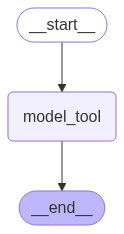

In [19]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node("model_tool", model_tool)
builder.add_edge(START, "model_tool")
builder.add_edge("model_tool", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
## invocation
messages=graph.invoke({"messages":"What is 4 plus 9"})

for message in messages["messages"]:
    message.pretty_print()

KeyError: 'messages'

In [26]:
tools = [add]

In [27]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

builder.add_node("model_tool", model_tool)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "model_tool")
builder.add_conditional_edges(
    "model_tool",
    #If the latest message (result) from assistant  is a tool call-> tools conditions routes to tools
    #If the latest message(result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", END)
graph_builder = builder.compile()

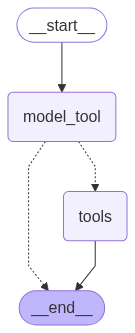

In [29]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [36]:
messages_new=graph_builder.invoke({"messages":"What is 4 plus 9"})

for message in messages_new["messages"]:
    message.pretty_print()

KeyError: 'messages'